# **Practical Work 2 (Extraordinary)**


Exercise 1 (Perceptron to classify penguin species)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler, LabelEncoder


1.   Exercise 1

The objective of exercise 1 is to construct a linear architecture (Perceptron) to develop a predictive model for identifying two penguin species (for instance: Gentoo and Adélie) based on the penguin characteristics: (1) bill_length_mm; (2) bill_depth_mm; (3) flipper_length_mm; and (4) body_mass_g.

Step 1 - Environment preparation



  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  


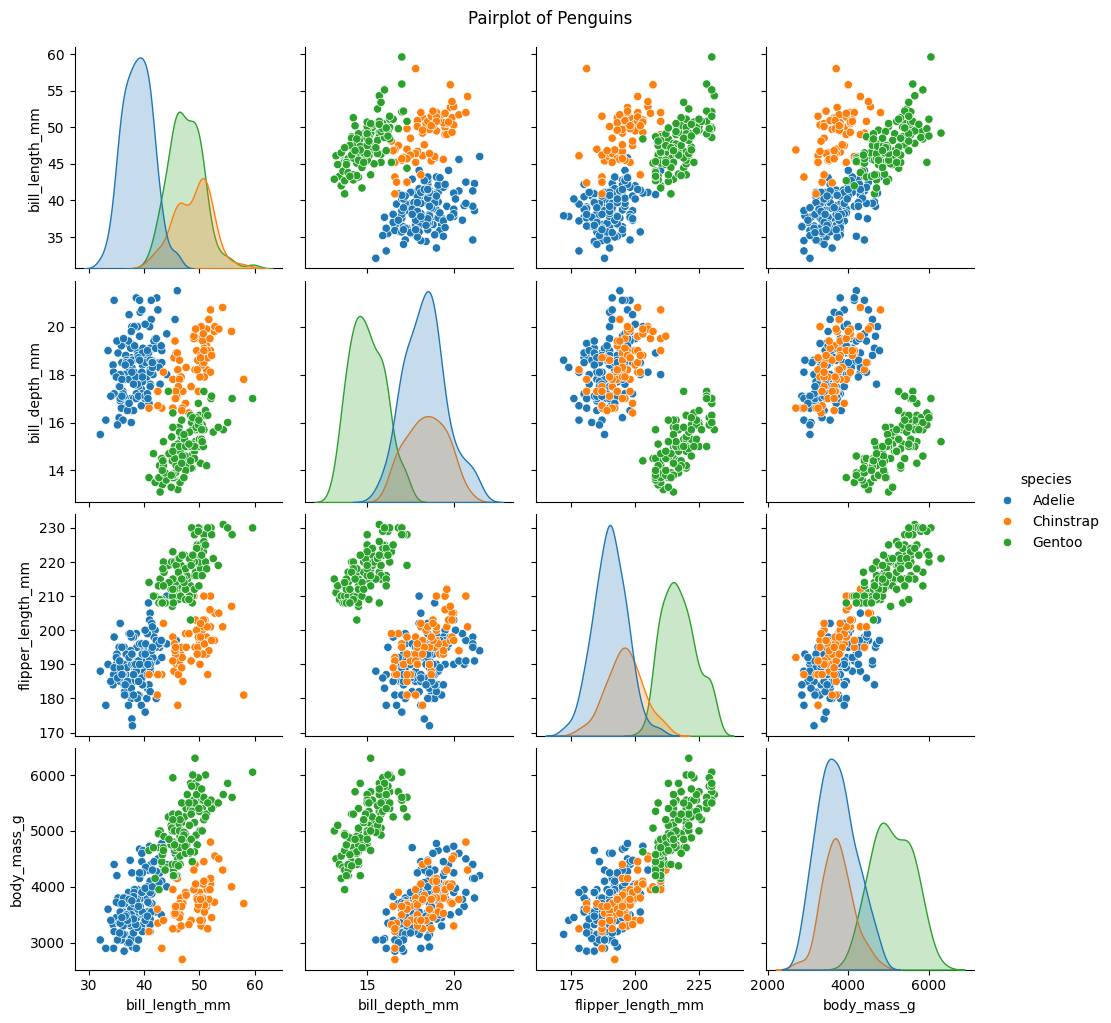

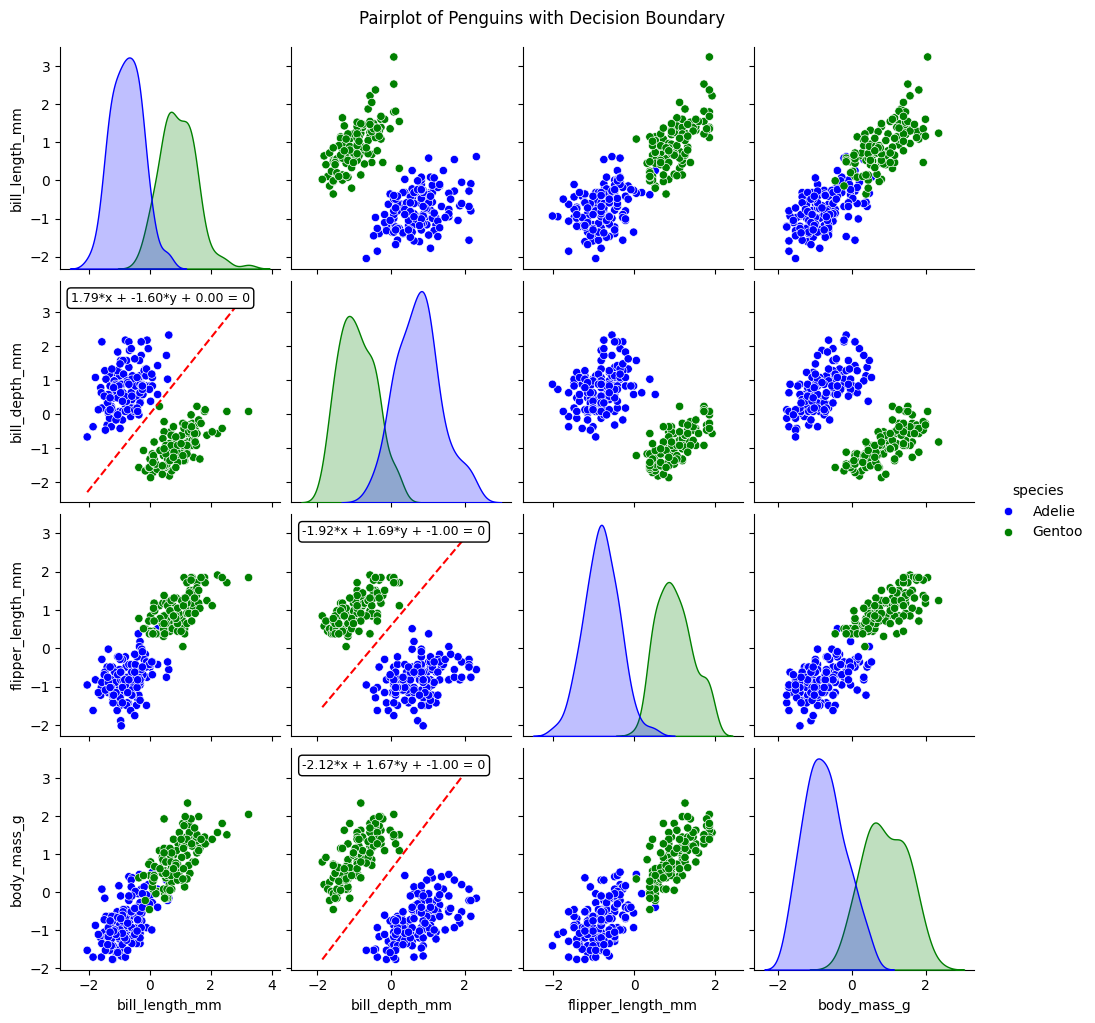

In [ ]:
# Cargar el dataset desde un archivo CSV
df = pd.read_csv('penguins.csv')

# Mostrar las primeras filas del dataset para verificar la carga
print(df.head())

# Eliminar filas con valores faltantes
df = df.dropna()

# Convertir todas las columnas pertinentes a tipos de datos apropiados
df_cleaned = df.astype({
    'bill_length_mm': 'float64',
    'bill_depth_mm': 'float64',
    'flipper_length_mm': 'float64',
    'body_mass_g': 'float64',
    'species': 'category'
})

# Eliminar las columnas 'sex' y 'island' del dataset original
df_cleaned = df_cleaned.drop(columns=['sex', 'island'])

# Crear pairplot para cada par de atributos después de la eliminación
pairplot = sns.pairplot(df_cleaned, hue='species')
pairplot.fig.suptitle('Pairplot of Penguins', y=1.02) # Ajustar y para una mejor posición del título
plt.show()

# Eliminar todas las filas donde la especie es 'Chinstrap'
df_cleaned = df_cleaned[df_cleaned['species'] != 'Chinstrap']

# Crear pairplot para cada par de atributos después de la eliminación
##pairplot = sns.pairplot(df_cleaned, hue='species')
##pairplot.fig.suptitle('Pairplot of Penguins', y=1.02) # Ajustar y para una mejor posición del título
##plt.show()

# Extraer características y etiquetas
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df_cleaned[features].values
y = df_cleaned['species'].values

# Codificar las especies como valores numéricos (Adelie = 0, Gentoo = 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Estandarizar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Filtrar el dataset para las dos especies seleccionadas de pingüinos (Adelie y Gentoo)
mask = (y_encoded == 0) | (y_encoded == 1)
X_binary = X[mask]
y_binary = y_encoded[mask]

# Crear DataFrame con los datos estandarizados para usar en el pairplot
df_standardized = pd.DataFrame(X_binary, columns=features)
df_standardized['species'] = y_binary

# Mapeo de 0 y 1 a nombres de especies
species_mapping = {0: 'Adelie', 1: 'Gentoo'}
df_standardized['species'] = df_standardized['species'].map(species_mapping)

# Definir y entrenar perceptrones para cada par de atributos
perceptrons = {}
pairs = [
    ('bill_length_mm', 'bill_depth_mm'),
    ('bill_depth_mm', 'flipper_length_mm'),
    ('bill_depth_mm', 'body_mass_g')
]

for (x_var, y_var) in pairs:
    X_pair = df_standardized[[x_var, y_var]].values
    y_pair = df_standardized['species'].values
    perceptron = Perceptron(max_iter=1000, random_state=0)
    perceptron.fit(X_pair, y_pair)
    perceptrons[(x_var, y_var)] = perceptron

# Función para calcular la frontera de decisión
def decision_boundary(x, weights, bias):
    return -(weights[0] * x + bias) / weights[1]

# Crear pairplot de los datos estandarizados
markers = ['o', 'o']
palette = {'Adelie': 'blue', 'Gentoo': 'green'}
g = sns.pairplot(df_standardized, hue='species', markers=markers, palette=palette)
plt.suptitle('Pairplot of Penguins with Decision Boundary', y=1.02)

# Añadir las fronteras de decisión y ecuaciones a los gráficos relevantes
for (x_var, y_var), perceptron in perceptrons.items():
    weights = perceptron.coef_[0]
    bias = perceptron.intercept_[0]
    x_values = np.linspace(df_standardized[x_var].min(), df_standardized[x_var].max(), 100)
    y_values = decision_boundary(x_values, weights, bias)

    # Crear la ecuación del hiperplano en formato string
    equation = f"{weights[0]:.2f}*x + {weights[1]:.2f}*y + {bias:.2f} = 0"

    for ax in g.axes.flat:
        if ax.get_xlabel() == x_var and ax.get_ylabel() == y_var:
            ax.plot(x_values, y_values, 'r--')
            # Añadir la ecuación como anotación en el gráfico
            ax.annotate(equation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=9,
                        ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.show()


Step 2 - Implementation



In [ ]:
  # Helper function to print the summary
def print_summary(epoch, weights, bias, total_error):
    print(f"Epoch: {epoch}, Weights: {weights}, Bias: {bias}, Total Error: {total_error}")

# Perceptron class definition with regularization
class Perceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=100, decay_rate=0.01):
        self.weights = np.random.uniform(-1, 1, input_size)
        self.bias = np.random.uniform(-1, 1)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.decay_rate = decay_rate

    def activation(self, x):
        return 1 if x >= 0 else 0

    def predict(self, x):
        return self.activation(np.dot(x, self.weights) + self.bias)

    def train(self, X, y):
        for epoch in range(self.epochs):
            total_error = 0
            for xi, target in zip(X, y):
                prediction = self.predict(xi)
                error = target - prediction
                self.weights += self.learning_rate * error * xi
                self.bias += self.learning_rate * error
                total_error += abs(error)
            self.learning_rate *= (1.0 / (1.0 + self.decay_rate * epoch))  # Update learning rate
            print_summary(epoch, self.weights, self.bias, total_error)
            if total_error == 0:
                break

# Train perceptrons with all combinations of attributes
perceptrons = {}
input_sizes = [2, 3, 4]
attribute_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

for input_size in input_sizes:
    combinations = list(itertools.combinations(range(len(attribute_names)), input_size))
    for combination in combinations:
        X_subset = X_binary[:, combination]
        perceptron = Perceptron(input_size=input_size, learning_rate=0.05, epochs=200)
        combination_names = [attribute_names[i] for i in combination]
        print(f"\nTraining Perceptron with inputs: {combination_names}")
        perceptron.train(X_subset, y_binary)
        perceptrons[tuple(combination)] = perceptron


Training Perceptron with inputs: ['bill_length_mm', 'bill_depth_mm']
Epoch: 0, Weights: [ 0.706011 -0.552444], Bias: 0.12143828208320227, Total Error: 16
Epoch: 1, Weights: [ 0.706011 -0.552444], Bias: 0.12143828208320227, Total Error: 0

Training Perceptron with inputs: ['bill_length_mm', 'flipper_length_mm']
Epoch: 0, Weights: [0.4935613  0.12148621], Bias: 0.07293406070668873, Total Error: 16
Epoch: 1, Weights: [0.38982488 0.26682268], Bias: -0.027065939293311275, Total Error: 8
Epoch: 2, Weights: [0.31516798 0.33381782], Bias: -0.07657088978836078, Total Error: 5
Epoch: 3, Weights: [0.29558626 0.33381782], Bias: -0.0765708897883608, Total Error: 2
Epoch: 4, Weights: [0.27657488 0.33381782], Bias: -0.0765708897883608, Total Error: 2
Epoch: 5, Weights: [0.25829471 0.33381782], Bias: -0.0765708897883608, Total Error: 2
Epoch: 6, Weights: [0.24668826 0.32806077], Bias: -0.0765708897883608, Total Error: 2
Epoch: 7, Weights: [0.23573877 0.3226296 ], Bias: -0.0765708897883608, Total Erro

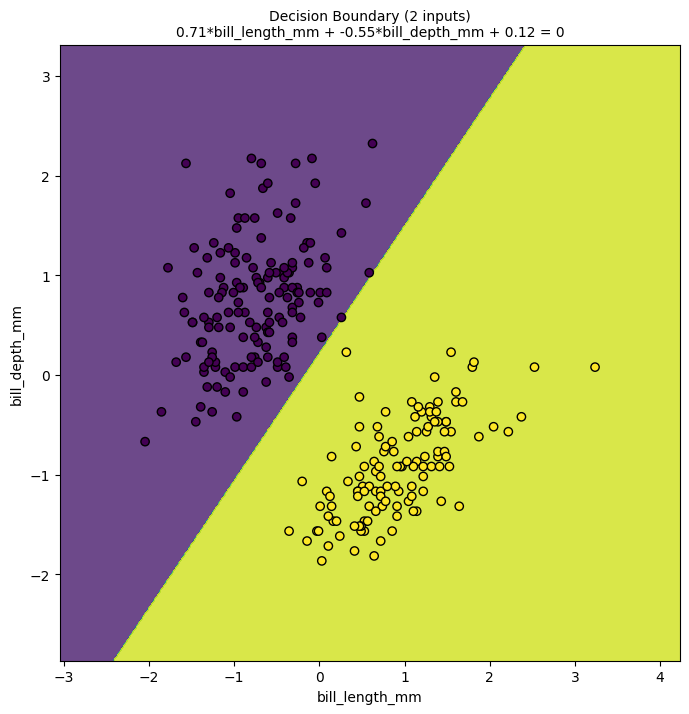

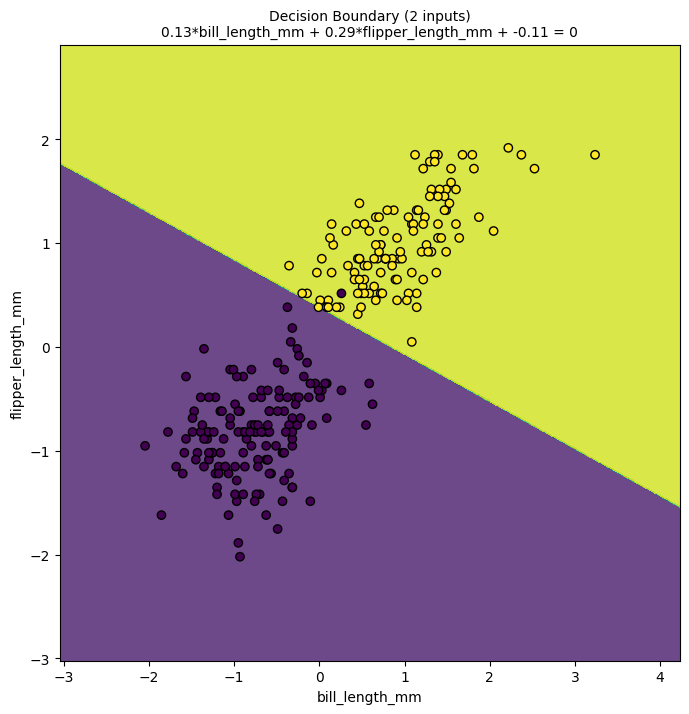

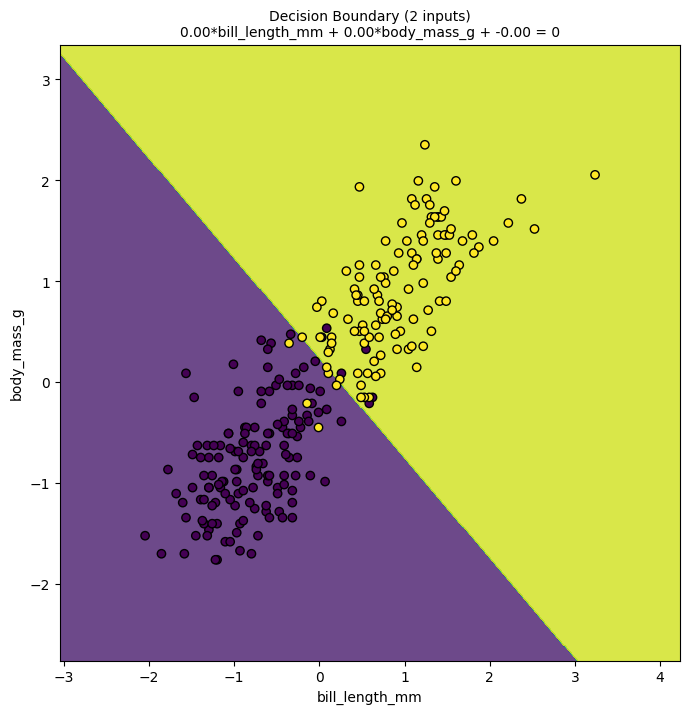

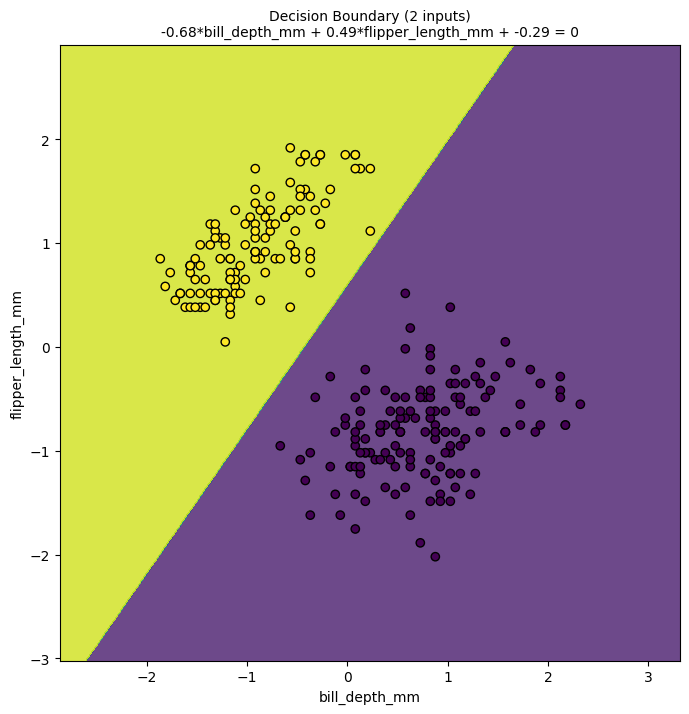

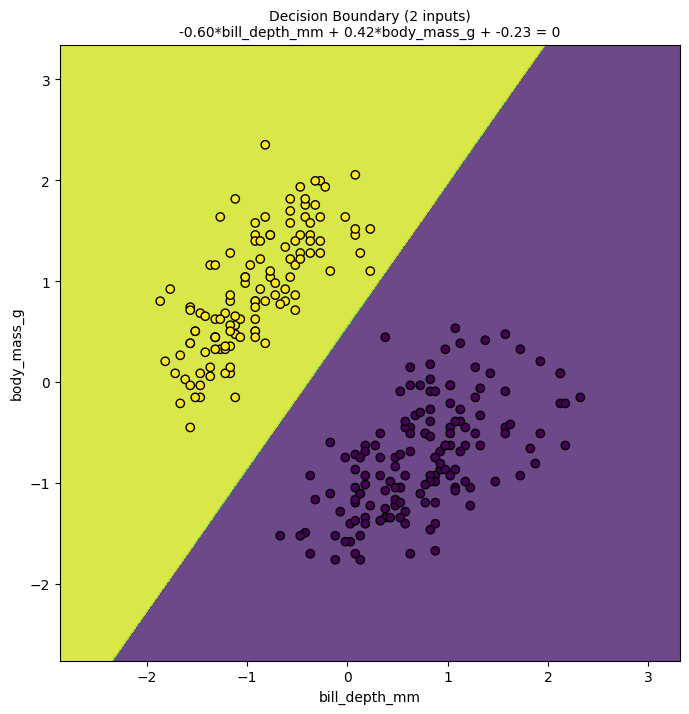

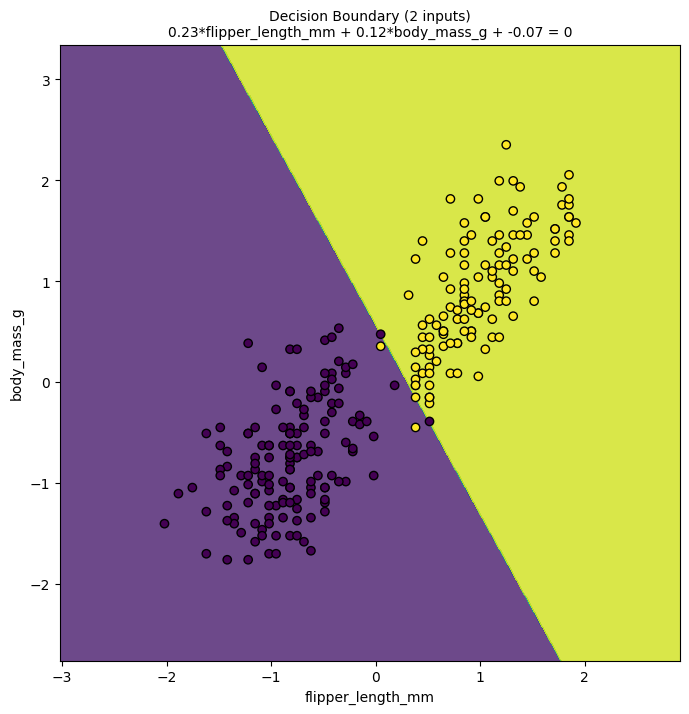

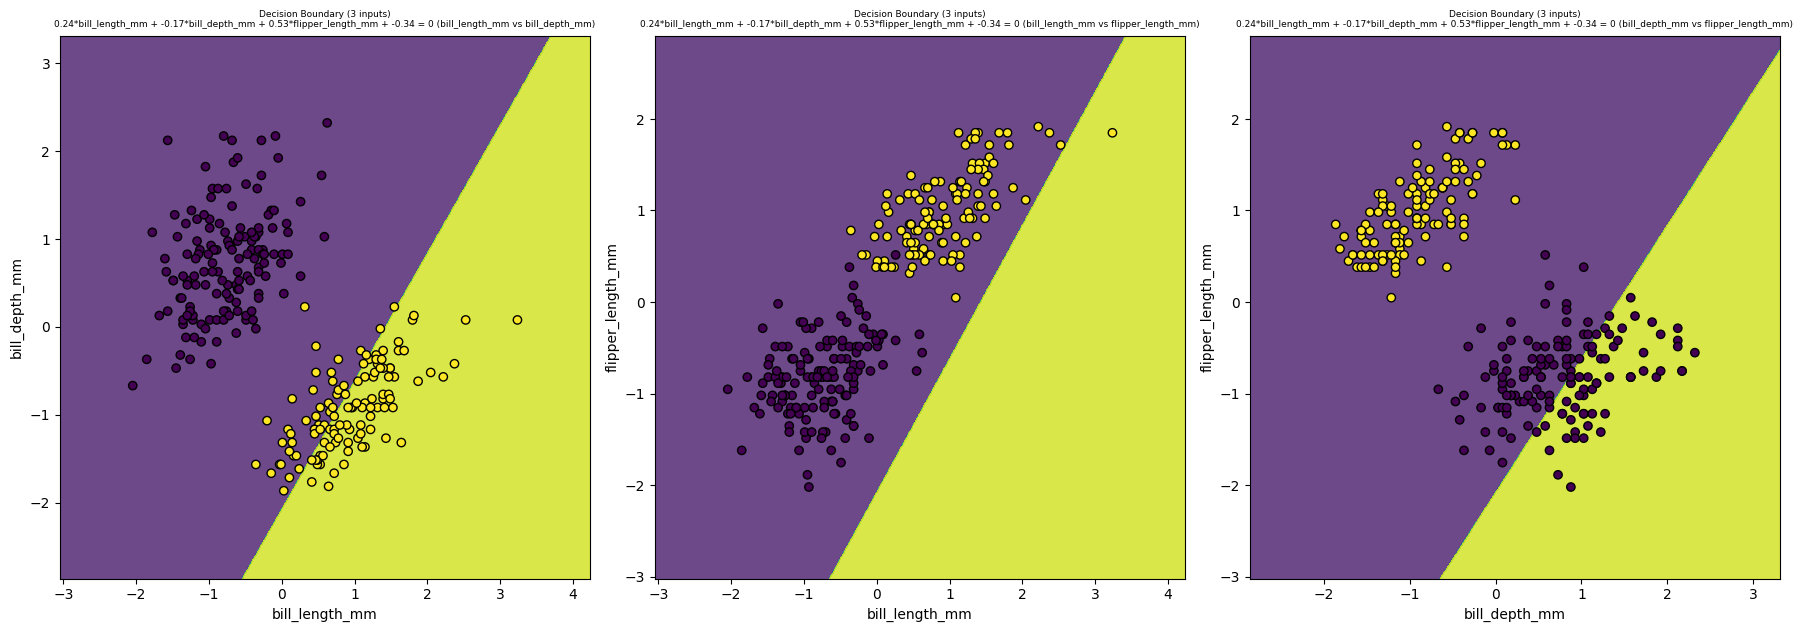

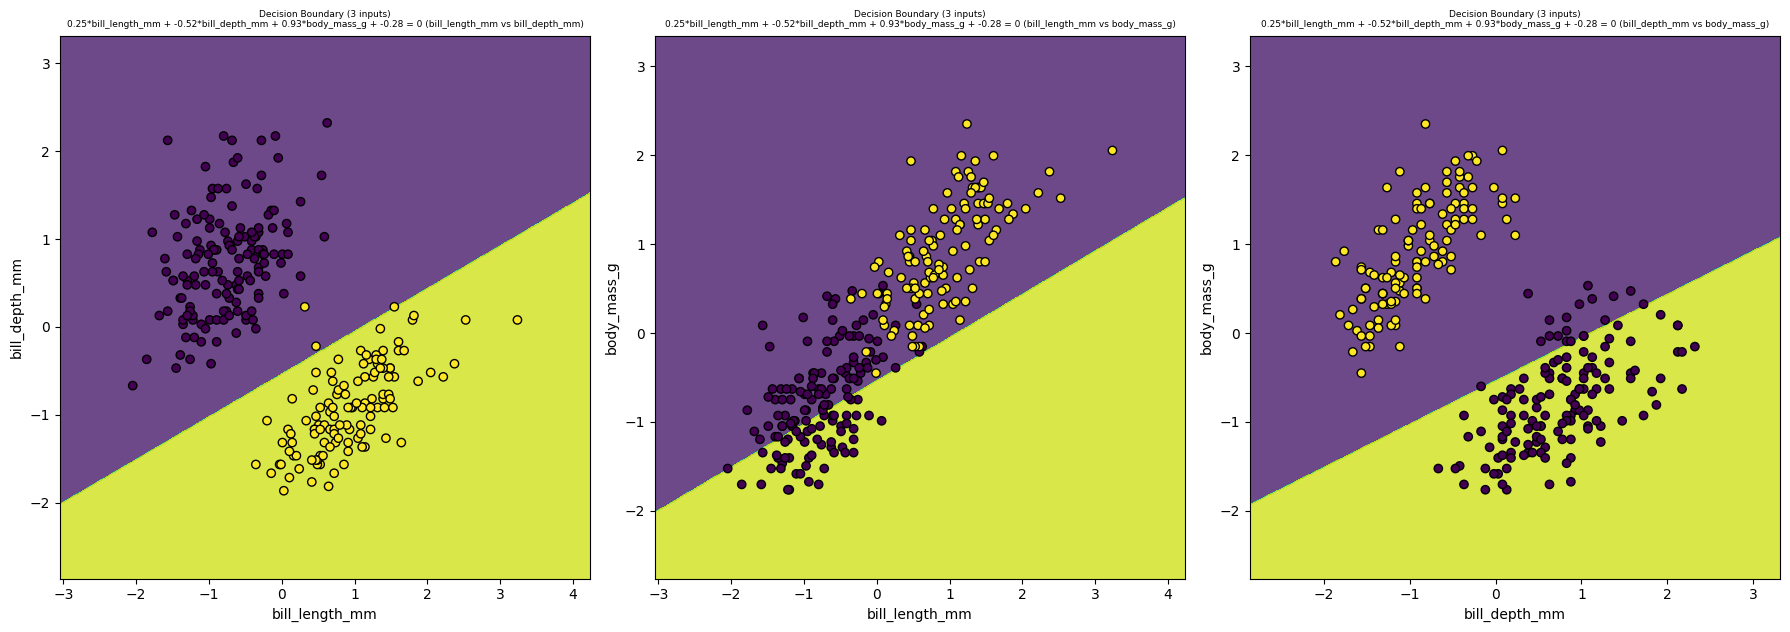

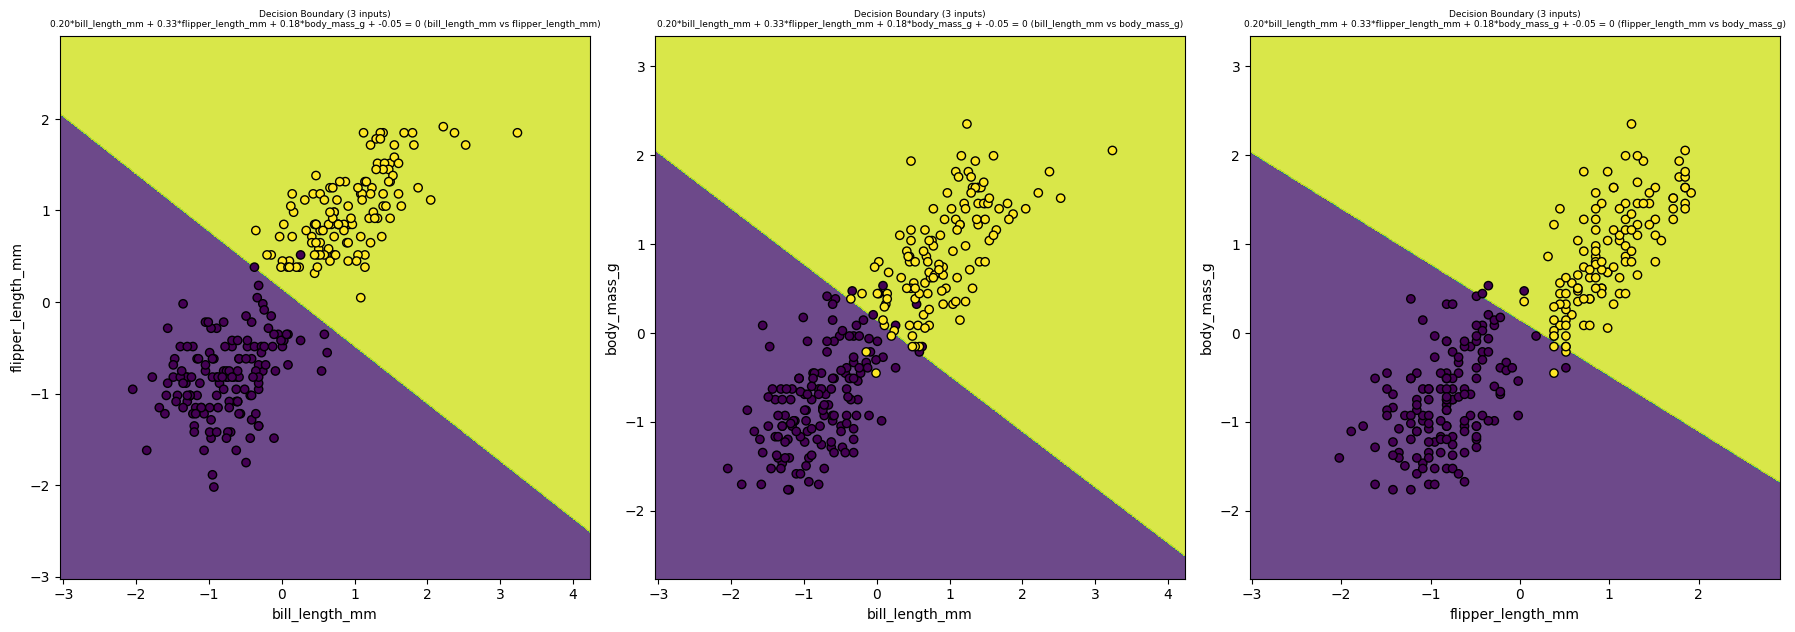

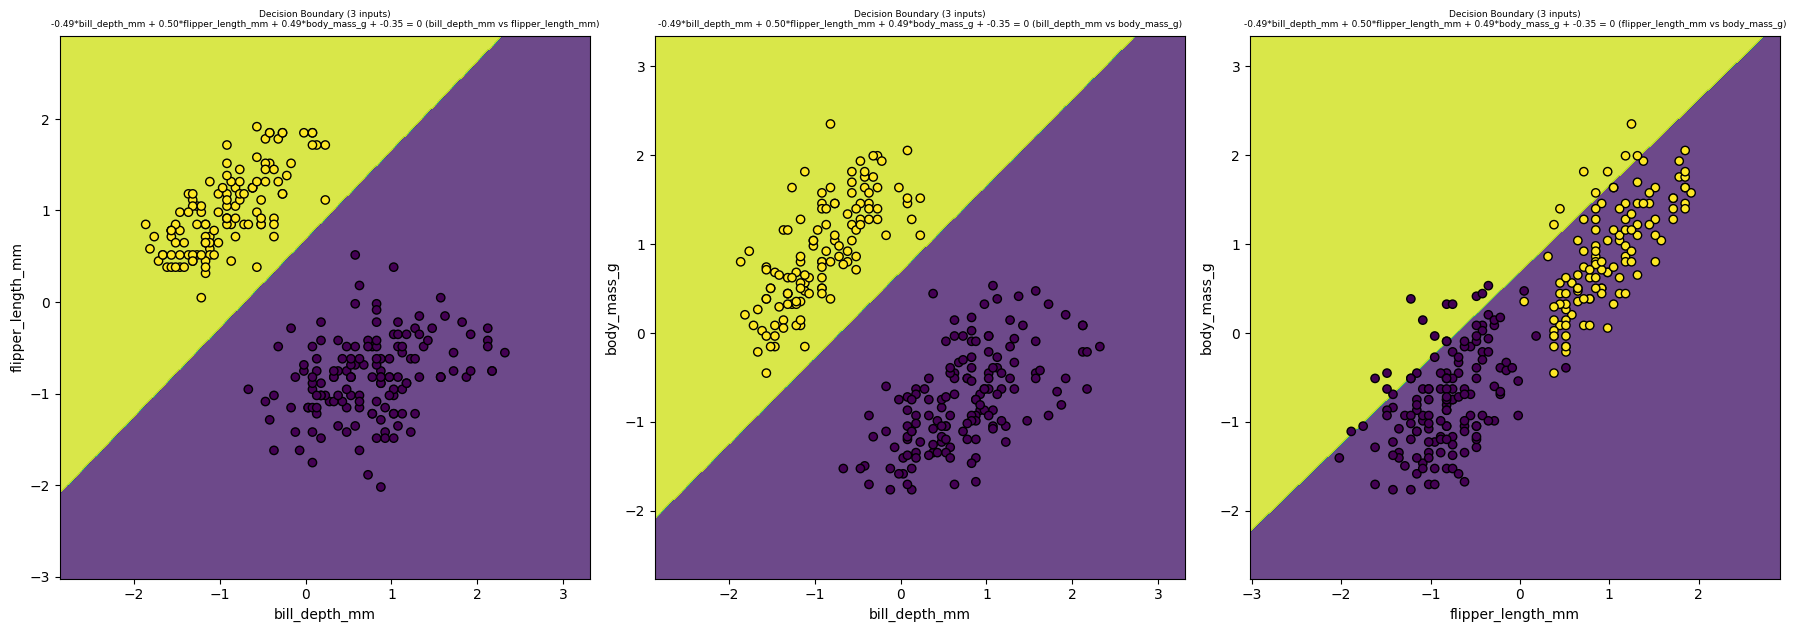

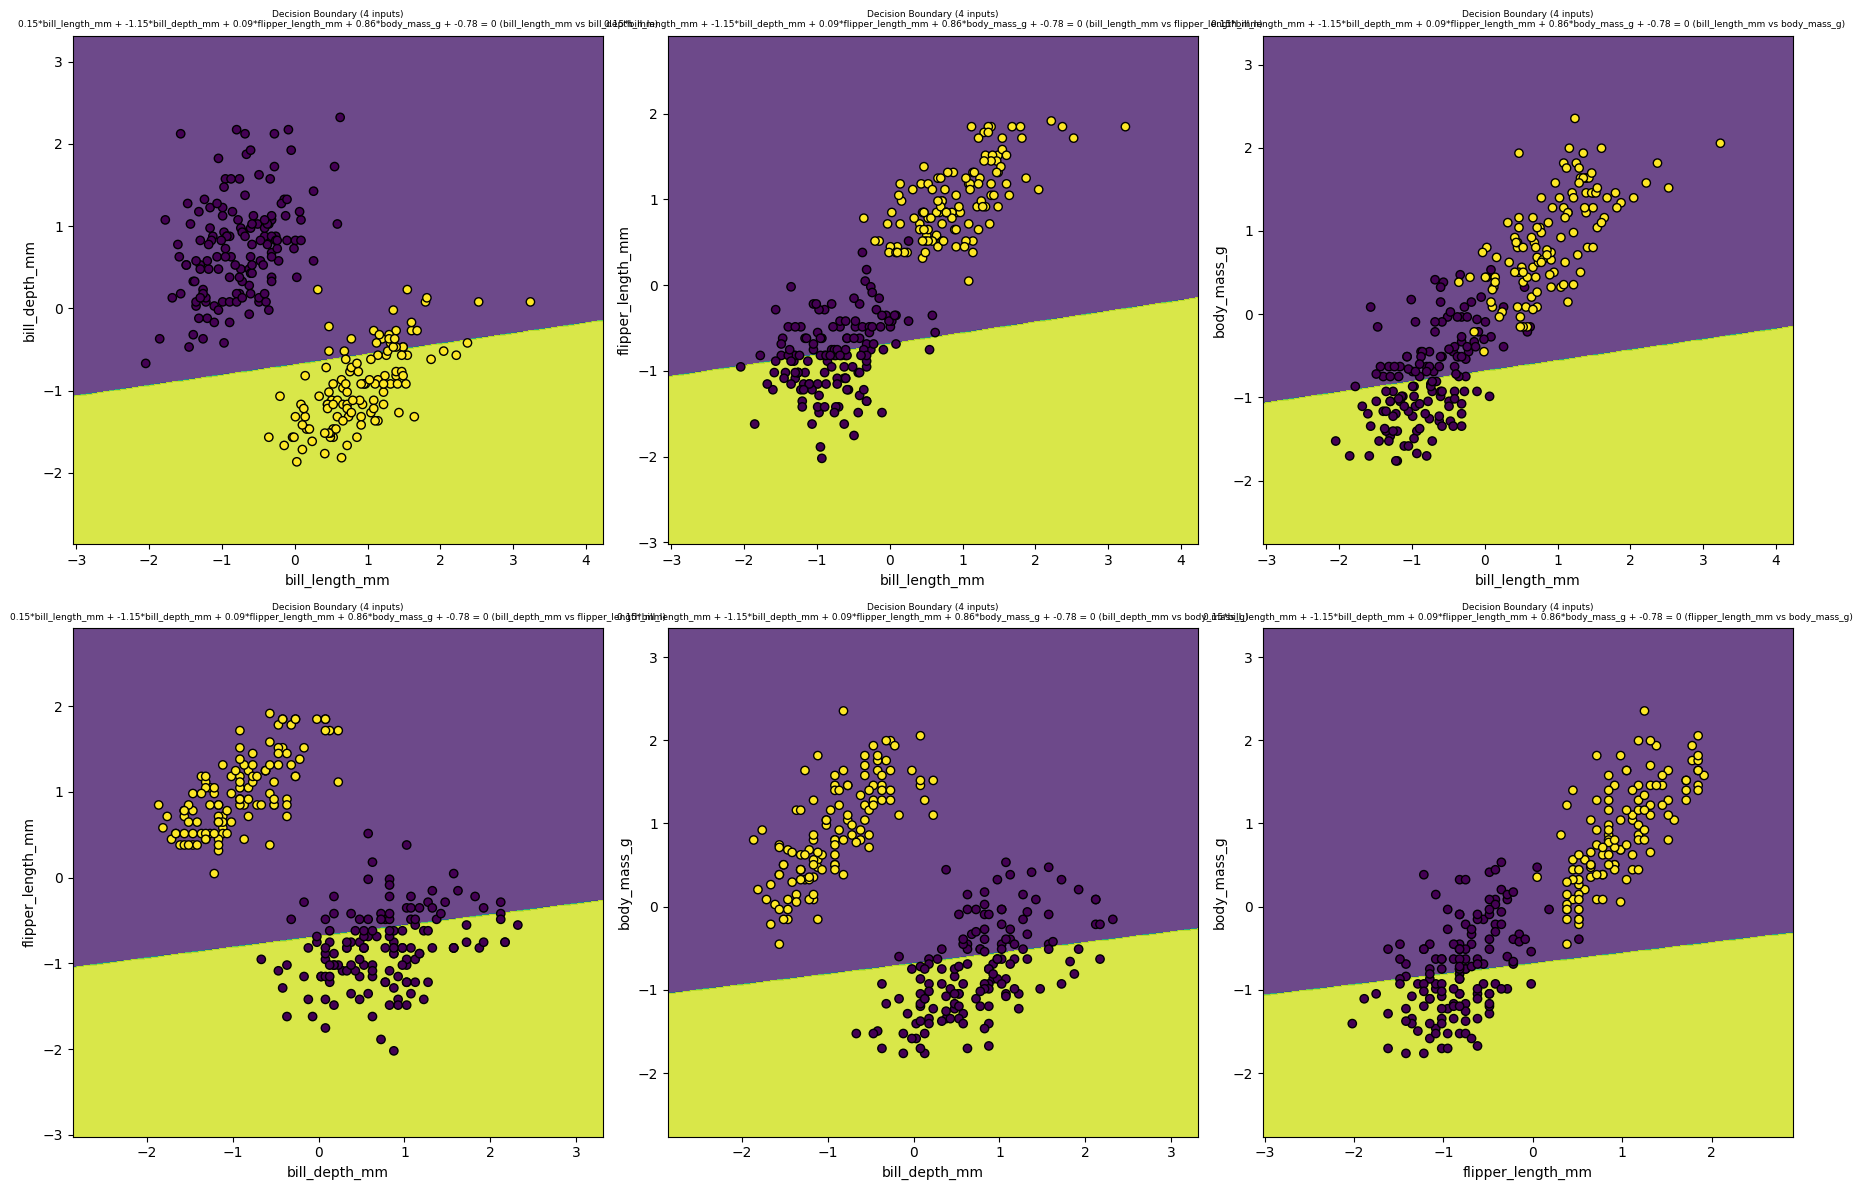

In [ ]:
def get_hyperplane_equation(weights, bias, attribute_names):
    terms = [f"{w:.2f}*{name}" for w, name in zip(weights, attribute_names)]
    equation = " + ".join(terms) + f" + {bias:.2f} = 0"
    return equation

def plot_decision_boundary_grid(X, y, model, title, input_size, attribute_names):
    if input_size == 2:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        Z = np.array([model.predict(np.array([x1, x2])) for x1, x2 in zip(xx.ravel(), yy.ravel())])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.8)
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
        hyperplane_equation = get_hyperplane_equation(model.weights, model.bias, attribute_names)
        ax.set_title(f"{title}\n{hyperplane_equation}", fontsize=10)
        ax.set_xlabel(attribute_names[0])
        ax.set_ylabel(attribute_names[1])
        plt.show()
    else:
        combinations = list(itertools.combinations(range(X.shape[1]), 2))
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        for ax, (i, j) in zip(axes, combinations):
            x_min, x_max = X[:, i].min() - 1, X[:, i].max() + 1
            y_min, y_max = X[:, j].min() - 1, X[:, j].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                 np.arange(y_min, y_max, 0.01))
            Z = np.array([model.predict(np.array([x1, x2] + [0] * (input_size - 2))) for x1, x2 in zip(xx.ravel(), yy.ravel())])
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, alpha=0.8)
            ax.scatter(X[:, i], X[:, j], c=y, edgecolors='k', marker='o')
            hyperplane_equation = get_hyperplane_equation(model.weights, model.bias, attribute_names)
            ax.set_title(f"{title}\n{hyperplane_equation} ({attribute_names[i]} vs {attribute_names[j]})", fontsize=6.5)
            ax.set_xlabel(attribute_names[i])
            ax.set_ylabel(attribute_names[j])
        for ax in axes[len(combinations):]:
            fig.delaxes(ax)
        plt.tight_layout()
        plt.show()

# Plot decision boundary for each trained perceptron
for combination, perceptron in perceptrons.items():
    combination_names = [attribute_names[i] for i in combination]
    X_subset = X_binary[:, combination]
    input_size = len(combination)
    plot_decision_boundary_grid(X_subset, y_binary, perceptron, f"Decision Boundary ({input_size} inputs)", input_size, combination_names)